In [1]:
%matplotlib inline
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Microsoft JhengHei']# 指定中文字型
plt.style.use('seaborn-whitegrid')

import seaborn as sns
sns.set_theme(color_codes=True)

### 讀取所有資料及整理

- 不使用任何跟站點有關參數(流量、轉乗數量等)
- 使用所有站點


In [2]:
# 讀取所有資料
path= '../data/'
file= 'all_data_final_v4_20210110.csv'
df = pd.read_csv( path+file ,encoding='utf-8')

print('所有欄位的名稱:\n',df.columns,'\n')

# 檢視不同營運狀態的站點數量 。1: 有運量資歷的站點、 10: 缺乏運量資料的站點(淡水輕軌)、0: 規劃中站點
print('各營運狀態站點數量:\n',df.groupby('Activated').size(),'\n')   

# 將咖啡店數量資料轉為類別資料，分為5個等級
df['Cat_Cafe'] = pd.qcut( df['Num_Cafe'], 5, labels=np.arange(5)) # np.arange(5) return 0~4
print('咖啡店分級',df.groupby('Cat_Cafe').size(),'\n')

# 填補缺值。注意目前主要流量料有缺值，另外租金資料為0的本身也是缺值
# df.fillna(value=0, inplace=True)
# print(df.isnull().any())

# 指定選取站點 選取所有資料
data = df
print('選取的站點數量:\n',data.groupby('Activated').size(),'\n') 

# print(data.isnull().any())  # 檢視缺值

所有欄位的名稱:
 Index(['Station_Type', 'Activated', 'Station_ID', 'Station_Name', 'T_Status',
       'Num_Transfer', 'Num_Atm', 'Num_Cstore', 'Num_Med', 'Num_Ele',
       'Num_Sec', 'Num_High', 'All_School', 'Num_POI', 'Num_Park',
       'Num_Village', 'Income_Gross', 'Income_Average', 'Population', 'Child',
       'Adult', 'Old_Age', 'Young_Adult', 'Middle_Age', 'Child_Dep', 'Old_Dep',
       'Higher_Edu', 'Sec_Edu', 'Ele_Edu', 'Uneducated', 'Male', 'Married',
       'Immigrant', 'Birth', 'Vol_All', 'Vol_Workday', 'Weekend',
       'Median_Rent', 'Num_Cafe', 'Num_Drink', 'Num_Bar', 'Num_Gym',
       'Num_Lodging', 'Cat_Vol', 'Cat_Rent', 'Cat_Cafe', 'Cat_Drink',
       'Cat_Bar', 'Cat_Gym', 'Cat_Lodging'],
      dtype='object') 

各營運狀態站點數量:
 Activated
0     105
1     173
10     14
dtype: int64 

咖啡店分級 Cat_Cafe
0    86
1    48
2    41
3    58
4    59
dtype: int64 

選取的站點數量:
 Activated
0     105
1     173
10     14
dtype: int64 



In [3]:
# data.loc[:,:'Birth'].describe()

In [4]:
# data.loc[:,'Vol_All':].describe()

## 模型訓練流程

1. 以 Accuracy做為評估指標，配合Cross Validation 初步篩選表現較佳的模型
  - Linear(SGD)、RandomForest、GBDT、SVM 
  - 先以各模型預設值進行測試
  - 同時檢視訓練與測試資料集
 
2. 從步驟1選出表現較好的模型，進一步進行超參數微調
  - 調整至訓練與測試資料集有接近表現為止
  
3. 訓練模型同時，也使用feature_importances_等參數檢視模型中各變數的解釋力


### 特徵選擇

- https://machinelearningmastery.com/calculate-feature-importance-with-python/https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [5]:
# 用來找出特徵值的函式  
'''輸入績效評估分數，回傳: 
   1. 重要特徵值的解釋力佔比 或
   2. 係數值(Lasso迴歸) 
'''
def feature_import(feature_score):
    feature_names =list(X.columns.values)  # 取得變數名稱
    feature_importances = {}               # 取得變數評分值 
    for var , score in zip(feature_names, feature_score):
        feature_importances.update( {var : score } )
#     print(f'{score:.3f} : {var} ')

    # 將特徵重要性依大小排序
    feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))  # 按value排序
    df = pd.DataFrame.from_dict(feature_importances,orient='index', columns=['socre'])
    
    if df['socre'].sum() <= 1.1:                 # 擷取隨機森林迴歸的重要值(所有權種合計為1)   
#         return print(df.head(15),'\n')                        # 傳回表 
        return  df.head(10).plot(kind="bar")   # 傳回圖

    else:
        df_coff = df[(df.values > 0.1)
                | (df.values < -0.1)]     # 擷取lasso迴歸的重要係數
#         return print(df_coff)                   # 傳回表  
        return  df_coff.plot(kind="bar")   # 傳回圖

In [6]:
# 用來顯示績效評分的的函式  
def display_scores(scores):
    print(f'Cross Validation Scores:{scores}')
    print(f'Mean_train  :{scores.mean():.3f}')
    print(f'Std_train  :{scores.std():.3f}\n')

In [7]:
# 資料集準備
from sklearn import preprocessing

# 在這邊手動設定預測項目
y = data['Cat_Cafe']

# 不使用任何跟站點有關參數(流量、轉乗數量等)

feature_selected = [
                    'Num_Atm', 'Num_Cstore', 'Num_Med', 'Num_Ele',
                    'Num_Sec', 'Num_High', 'Num_POI', 'Num_Park',
                    'Income_Gross', 'Income_Average', 'Population', 'Child',
                     'Old_Age', 'Young_Adult', 'Middle_Age', 'Child_Dep', 'Old_Dep',
                    'Higher_Edu', 'Sec_Edu', 'Ele_Edu', 'Uneducated', 'Male', 'Married',
                    'Immigrant', 'Birth'
                    ] 

X = data[feature_selected]

# print(X.dtypes)

# 採用label encoder 將類別資料轉為數值型態
# label_encoder = preprocessing.LabelEncoder()
# encoded_S_Type = label_encoder.fit_transform(X['Station_Type'])
# X.loc[:,'Station_Type'] = encoded_S_Type.copy()



### 使用Cross Validation 進行模型績效比較

### Linear_model(SGDClassifier)

In [9]:
# 線性回歸模型
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size= 0.2, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

model = SGDClassifier()
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# 訓練集Cross Validation
print('Train data:\n')
SGD_scores = cross_val_score(model, X_train, y_train,
         scoring='accuracy',cv=5 )
display_scores(SGD_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')
accuracy_test = accuracy_score(y_test, y_pred)
num_correct_samples = accuracy_score(y_test, y_pred, normalize=False)
con_matrix = confusion_matrix(y_test, y_pred)

# print(f'Number of correct sample: {num_correct_samples}')
print(f'Accuracy_test: {accuracy_test:.3f}\n')

# 測試資料混淆矩陣
# sns.heatmap(con_matrix.T, square=True, annot=True, fmt='d', cbar=False)
# plt.xlabel('true label')
# plt.ylabel('faldse label')

# 檢視分類報告
print('Classification Report:\n')
from sklearn.metrics import classification_report
print(classification_report( y_test, y_pred))

Train data:

Cross Validation Scores:[0.5106383  0.44680851 0.44680851 0.5        0.41304348]
Mean_train  :0.463
Std_train  :0.036

--------------------------------------------------
Test data:

Accuracy_test: 0.373

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.22      0.18      0.20        11
           2       0.00      0.00      0.00         7
           3       0.33      0.50      0.40        16
           4       1.00      0.31      0.47        13

    accuracy                           0.37        59
   macro avg       0.43      0.33      0.34        59
weighted avg       0.48      0.37      0.38        59



### RandomForest

Train data:

Cross Validation Scores:[0.68085106 0.57446809 0.61702128 0.58695652 0.56521739]
Mean_train  :0.605
Std_train  :0.042

--------------------------------------------------
Test data:

Accuracy_test: 0.610

Classification Report:

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        12
           1       0.50      0.27      0.35        11
           2       0.17      0.14      0.15         7
           3       0.64      0.56      0.60        16
           4       0.92      0.85      0.88        13

    accuracy                           0.61        59
   macro avg       0.56      0.56      0.54        59
weighted avg       0.61      0.61      0.59        59



<AxesSubplot:>

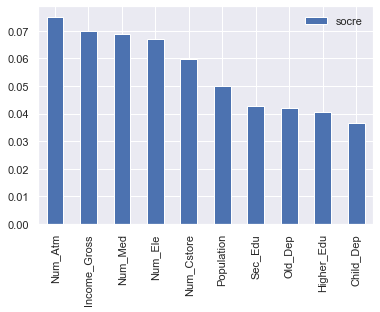

In [10]:
 # 隨機森林迴歸分類器 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  accuracy_score, confusion_matrix, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# max_depth=5, n_estimators=100
model = RandomForestClassifier(n_jobs=-1)  # class_weight={ 'balanced','balanced_subsample'}
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# 訓練資料Cross Validation
print('Train data:\n')
RF_scores = cross_val_score(model, X_train, y_train,
                            scoring='accuracy', cv=5 )
display_scores(RF_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')
accuracy_test = accuracy_score(y_test, y_pred)
num_correct_samples = accuracy_score(y_test, y_pred, normalize=False)
con_matrix = confusion_matrix(y_test, y_pred)

# print(f'Number of correct sample: {num_correct_samples}')
print(f'Accuracy_test: {accuracy_test:.3f}\n')

# 測試集混淆矩陣
# sns.heatmap(con_matrix.T, square=True, annot=True, fmt='d', cbar=False)
# plt.xlabel('true label')
# plt.ylabel('faldse label')

# 檢視分類報告
print('Classification Report:\n')
from sklearn.metrics import classification_report
print(classification_report( y_test, y_pred))

# 檢視特徵重要性
feature_score = model.feature_importances_
feature_import(feature_score)

### SVM

In [11]:
# SVM
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# we can change kernel to rbf, poly, linear
model = SVC(kernel='rbf')
# svm_reg = SVC(kernel='linear')
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)

# 訓練資料Cross Validation
print('Train data:\n')
SVM_scores = cross_val_score(model, X_train, y_train,
                             scoring='accuracy',cv=5 )
display_scores(SVM_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')
accuracy_test = accuracy_score(y_test, y_pred)
num_correct_samples = accuracy_score(y_test, y_pred, normalize=False)
con_matrix = confusion_matrix(y_test, y_pred)

# print(f'Number of correct sample: {num_correct_samples}')
print(f'Accuracy_test: {accuracy_test:.3f}\n')

# 測試集混淆矩陣
# sns.heatmap(con_matrix.T, square=True, annot=True, fmt='d', cbar=False)
# plt.xlabel('true label')
# plt.ylabel('faldse label')

# 檢視分類報告
print('Classification Report:\n')
from sklearn.metrics import classification_report
print(classification_report( y_test, y_pred))

Train data:

Cross Validation Scores:[0.63829787 0.57446809 0.59574468 0.63043478 0.58695652]
Mean_train  :0.605
Std_train  :0.025

--------------------------------------------------
Test data:

Accuracy_test: 0.542

Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.17      0.09      0.12        11
           2       0.12      0.14      0.13         7
           3       0.58      0.44      0.50        16
           4       0.92      0.92      0.92        13

    accuracy                           0.54        59
   macro avg       0.47      0.50      0.47        59
weighted avg       0.52      0.54      0.52        59



### GradientBoostingClassifier

Train data:

Cross Validation Scores:[0.60377358 0.49056604 0.65384615 0.59615385 0.46153846]
Mean_train  :0.561
Std_train  :0.073

--------------------------------------------------
Test data:

Accuracy_test: 0.667

Classification Report:

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.50      0.14      0.22         7
           2       0.00      0.00      0.00         2
           3       0.62      0.83      0.71         6
           4       1.00      0.86      0.92         7

    accuracy                           0.67        30
   macro avg       0.57      0.57      0.54        30
weighted avg       0.67      0.67      0.63        30



<AxesSubplot:>

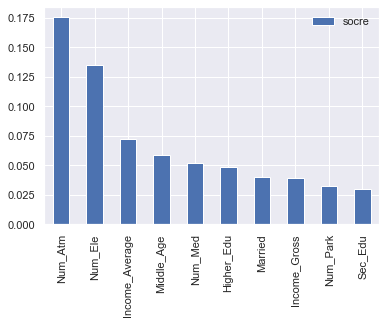

In [12]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

X_test = scaler.transform(X_test)
y_pred = model.predict(X_test)


# 訓練資料Cross Validation
print('Train data:\n')
GBDT_scores = cross_val_score(model, X_train, y_train,
                              scoring='accuracy', cv=5 )
display_scores(GBDT_scores)

print('-'*50)

# 測試資料績效評估
print('Test data:\n')
accuracy_test = accuracy_score(y_test, y_pred)
num_correct_samples = accuracy_score(y_test, y_pred, normalize=False)
con_matrix = confusion_matrix(y_test, y_pred)

# print(f'Number of correct sample: {num_correct_samples}')
print(f'Accuracy_test: {accuracy_test:.3f}\n')

# 測試集混淆矩陣
# sns.heatmap(con_matrix.T, square=True, annot=True, fmt='d', cbar=False)
# plt.xlabel('true label')
# plt.ylabel('faldse label')

# 檢視分類報告
print('Classification Report:\n')
from sklearn.metrics import classification_report
print(classification_report( y_test, y_pred))

# 檢視特徵重要性
feature_score = model.feature_importances_
feature_import(feature_score)

### 作圖比較各模型在Cross Validation後的評估分數

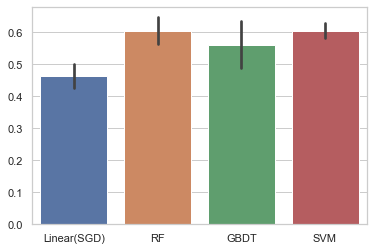

In [13]:
from numpy import median,mean
sns.set_theme(style="whitegrid")

data = {'Linear(SGD)' :SGD_scores,
        'RF' :RF_scores,
        'GBDT':GBDT_scores,
        'SVM' :SVM_scores }

df_CV =pd.DataFrame(data)

ax = sns.barplot(data=df_CV, estimator=mean, ci="sd",   )
# y ='RMSE_Score'

### 微調超參數
- 隨機搜尋

nan {'class_weight': 'none', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 81}
0.571 {'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 476}
nan {'class_weight': 'none', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 97}
0.559 {'class_weight': 'balanced', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 673}
nan {'class_weight': 'none', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 501}
0.580 {'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 201}
0.502 {'class_weight': 'balanced', 'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 323}
0.580 {'class_weight': 'balanced_subsample', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 570}
nan {'class_weight': 'none', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 485}
nan {'class_weight': 'none', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 572}
nan {'class_weight': 'none', 'max_depth': 3, 'm

<AxesSubplot:>

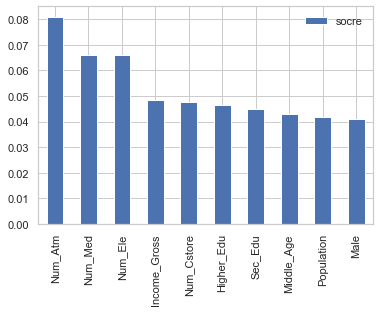

In [17]:
# RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import  accuracy_score, confusion_matrix, mean_squared_error
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

param_distribs = {
    'n_estimators': randint(low=10, high=10**3),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(low=1, high=20),
     'class_weight':['balanced','balanced_subsample','none']  #{“balanced”, “balanced_subsample”}
    }

forest_clf = RandomForestClassifier(n_jobs=-1)
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=30, cv=10, scoring='accuracy',n_jobs=-1 , random_state=42)
rnd_search.fit(X_train, y_train)

cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'{mean_score:.3f}' , params)

# 檢視最佳參數
print(rnd_search.best_estimator_)

# 檢視特徵重要性
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_score = feature_importances
feature_import(feature_score)

Test data:

Accuracy_test: 0.644

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.88      0.73        17
           1       0.67      0.20      0.31        10
           2       0.43      0.38      0.40         8
           3       0.50      0.58      0.54        12
           4       1.00      0.92      0.96        12

    accuracy                           0.64        59
   macro avg       0.64      0.59      0.59        59
weighted avg       0.66      0.64      0.62        59



<AxesSubplot:>

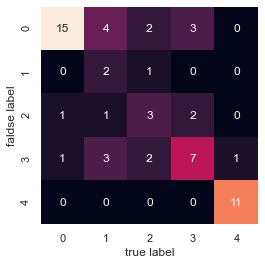

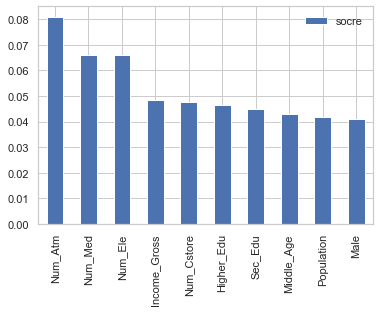

In [18]:
# 產出最佳模型
final_model = rnd_search.best_estimator_
X_test = scaler.transform(X_test)
y_pred = final_model.predict(X_test)

# 測試資料績效評估
print('Test data:\n')
accuracy_test = accuracy_score(y_test, y_pred)
num_correct_samples = accuracy_score(y_test, y_pred, normalize=False)
con_matrix = confusion_matrix(y_test, y_pred)

# print(f'Number of correct sample: {num_correct_samples}')
print(f'Accuracy_test: {accuracy_test:.3f}\n')

# 檢視分類報告
print('Classification Report:\n')
from sklearn.metrics import classification_report
print(classification_report( y_test, y_pred))

# 測試集混淆矩陣
sns.heatmap(con_matrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('faldse label')

# 檢視特徵重要性
feature_score = final_model.feature_importances_
feature_import(feature_score)

### Model persistence using joblib

In [19]:
# my_model = final_model
# import joblib
# joblib.dump(my_model, "cafe_model_cla(nonVol).pkl") # DIFF
# #...
# my_model_loaded = joblib.load("cafe_model_cla(nonVol).pkl") # DIFF

### 繪製學習曲線

Training sizes: [ 26  85 144 203 262] 

Training scores:
  [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] 


Test scores:
 [[0.23333333 0.56666667 0.44827586 0.5862069  0.24137931 0.34482759
  0.48275862 0.48275862 0.31034483 0.4137931 ]
 [0.26666667 0.7        0.75862069 0.55172414 0.31034483 0.68965517
  0.65517241 0.4137931  0.31034483 0.48275862]
 [0.43333333 0.63333333 0.65517241 0.48275862 0.37931034 0.5862069
  0.62068966 0.44827586 0.34482759 0.44827586]
 [0.5        0.6        0.5862069  0.48275862 0.4137931  0.62068966
  0.5862069  0.48275862 0.31034483 0.24137931]
 [0.6        0.66666667 0.55172414 0.62068966 0.4137931  0.62068966
  0.5862069  0.4137931  0.37931034 0.44827586]] 

----------------------------------------------------------------------
Mean training scores

 26     1.0
85     1.0
144    1.0
203    1.0
262    1.0
dtype: float64

 ---------------

(0.0, 1.1)

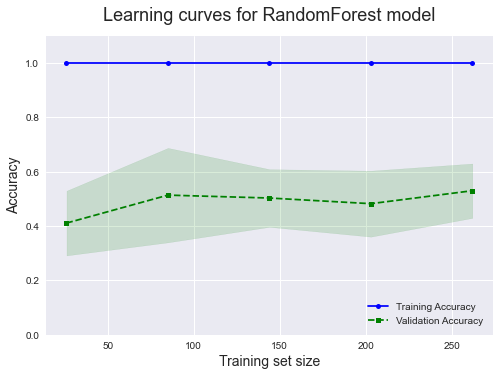

In [32]:
from sklearn.model_selection import learning_curve
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

train_sizes, train_scores, test_scores = learning_curve(
    estimator = final_model, X=X, y=y, 
    train_sizes= np.linspace(0.1, 1.0, 5), 
    scoring='accuracy', cv=10, n_jobs=-1)

print('Training sizes:',train_sizes, '\n') 
print('Training scores:\n ',train_scores, '\n')
print('\nTest scores:\n',test_scores, '\n')
print( '-' * 70)

train_scores_mean = train_scores.mean(axis = 1)
test_scores_mean = test_scores.mean(axis = 1 )
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(test_scores_mean, index = train_sizes))

# 繪圖
import matplotlib.pyplot as plt
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('seaborn')

plt.plot(train_sizes, train_mean, color='blue' ,marker='o' ,markersize=5, label = 'Training Accuracy')
plt.fill_between(train_sizes,
                train_mean+train_std,
                train_mean-train_std,
                alpha=0.15,color='blue'
                )
plt.plot(train_sizes, test_mean, color='green' ,marker='s' ,markersize=5, linestyle='--',  label = 'Validation Accuracy')

plt.fill_between(train_sizes,
                test_mean+test_std,
                test_mean-test_std,
                alpha=0.15,color='green' 
                )

plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for RandomForest model', fontsize = 18, y = 1.03)
plt.legend(loc='lower right')
plt.ylim(0,1.1)

## 用訓練出的模型取出預測值

### 取出測試資料預測的y值

In [22]:
# 取出預測的y值， 注意這邊取得的預測值是最後跑的那個model
index = y_test.index

y_pred = pd.DataFrame( y_pred.reshape(-1,1).round(3), index=index, columns=['Prediction'])

dataset = [df['Station_Name'], pd.DataFrame(y_test), y_pred ] 

df_y_pred = pd.concat(dataset, join='inner' , axis=1)

# df_y_pred['P_Store'] = (df_y_pred['Prediction'] - df_y_pred[y.name]) 
# df_y_pred['Potential'] = (df_y_pred['Prediction'] - df_y_pred[y.name])/df_y_pred['Prediction']*100

df_y_pred 

,Station_Name,Cat_Cafe,Prediction
2,土城站,0,0
3,海山站,1,1
5,府中站,4,4
11,忠孝敦化站,4,4
17,南港站,2,2
18,動物園站,0,0
42,新店區公所站,3,3
47,萬隆站,3,3
52,西門站,4,4
53,北門站,4,4


### 將模型套用在未營運的站點 取得預測值

In [23]:
from sklearn import preprocessing

def get_pred_data():

    df  = pd.read_csv( path+file ,encoding='utf-8')
    model = final_model

    # 將咖啡店數量資料轉為類別資料，分為5個等級
    df['Num_Cafe'] = df['Num_Cafe'].astype(float)
    df['Cat_Cafe'] = pd.qcut(df['Num_Cafe'], 5, labels=np.arange(5)) # np.arange(5) return 0~4
    
    X = df[feature_selected]

    # 採用label encoder 將類別資料轉為數值型態
#     label_encoder = preprocessing.LabelEncoder()
#     encoded_S_Type = label_encoder.fit_transform(X['Station_Type'])
#     X.loc[:,'Station_Type'] = encoded_S_Type.copy()

    #正規化
    X = scaler.transform(X)

    # 設定要使用的模型， 注意這邊使用的model是最後跑的那個
    y = model.predict(X)

    y = pd.DataFrame(y.reshape(-1,1).round(0), index=df.index, columns=['Cat_Cafe_Pre']) #取整數

    dataset = [df, y ] 

    df_pred = pd.concat(dataset, join='inner' , axis=1)
    
    #     將轉乘數量從LOG(base=e)轉換回去
    import math
    df_pred['Num_Transfer'] = (math.e)**(df_pred['Num_Transfer'])
    
#     增加展店潛力欄位
    df_pred['Potential'] = df_pred['Cat_Cafe_Pre'].astype(float) - df_pred['Cat_Cafe'].astype(float)
    df_pred['Cat_Cafe'] = df_pred['Cat_Cafe'].astype(float) # 轉成浮點數
        
    return df_pred

get_pred_data()

,Station_Type,Activated,Station_ID,Station_Name,T_Status,Num_Transfer,Num_Atm,Num_Cstore,Num_Med,Num_Ele,...,Num_Lodging,Cat_Vol,Cat_Rent,Cat_Cafe,Cat_Drink,Cat_Bar,Cat_Gym,Cat_Lodging,Cat_Cafe_Pre,Potential
0,TpMrt,1,BL01,頂埔站,N,1.0,13,6,6,5,...,0.0,6.0,2,0.0,0,0,0,0,0,0.0
1,TpMrt,1,BL02,永寧站,N,1.0,11,5,1,9,...,0.0,7.0,1,2.0,0,0,0,0,2,0.0
2,TpMrt,1,BL03,土城站,N,1.0,22,10,28,7,...,1.0,6.0,2,0.0,0,0,1,0,0,0.0
3,TpMrt,1,BL04,海山站,N,1.0,40,22,41,26,...,0.0,7.0,2,1.0,0,0,1,0,1,0.0
4,TpMrt,1,BL05,亞東醫院站,N,1.0,19,8,9,18,...,0.0,8.0,1,2.0,0,0,0,0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Train,1,1100,中壢站,N,1.0,48,20,84,17,...,6.0,8.0,2,4.0,0,3,1,0,4,0.0
288,Train,1,1110,埔心站,N,1.0,11,7,17,8,...,0.0,6.0,1,1.0,1,0,0,0,1,0.0
289,Train,1,1120,楊梅站,N,1.0,17,7,25,16,...,1.0,6.0,1,1.0,2,0,0,0,1,0.0
290,Train,1,1130,富岡站,N,1.0,5,3,1,3,...,0.0,5.0,1,0.0,0,0,0,0,0,0.0


In [24]:
# 檢視展店潛力
df = get_pred_data()

positive_Pot = df.loc[df['Potential']>0,'Station_Name']
negative_Pot = df.loc[df['Potential']<0,'Station_Name']

print(f'Positive_Potential:{positive_Pot.size} ,{positive_Pot.values}')
print()
print(f'Negative_Potential:{negative_Pot.size} ,{negative_Pot.values}')

Positive_Potential:8 ,['廷寮站(規劃中)' '中華中學站(規劃中)' '彭福站(規劃中)' '唭哩岸站' '復興崗站' '景平站' '陽明公園站(規劃中)'
 '大檜溪站(規劃中)']

Negative_Potential:13 ,['育林國小站(規劃中)' '關渡站' '政大站(規劃中)' '寶斗厝站(規劃中)' '新莊副都心站' '泰山貴和站' '高鐵桃園站'
 '永和市場站(規劃中)' '中壢高中站(規劃中)' '新街站(規劃中)' '雙溪站' '八斗子站' '海科館站']


In [25]:
import sys,os,time

# Where to save the data
PROJECT_ROOT_DIR = "../"
dir_name = "prediction_result/"
DATA_PATH = os.path.join(PROJECT_ROOT_DIR,dir_name)
os.makedirs(DATA_PATH, exist_ok=True)

def save_data(file_name):
    df = get_pred_data().copy()
    df.to_csv( DATA_PATH + file_name ,encoding='utf-8')
    print("Saving DATA:", file_name)

time =time.strftime("%y%m%d_%H%M") #將時間資料寫入檔案名稱 
save_data(f'Cat_Cafe_Pre(nonVol)_{time}.csv')


Saving DATA: Cat_Cafe_Pre(nonVol)_210123_1506.csv


In [26]:
df_pred = get_pred_data()
print(df_pred.groupby('Cat_Cafe').size())
print(df_pred.groupby('Cat_Cafe_Pre').size())

Cat_Cafe
0.0    86
1.0    48
2.0    41
3.0    58
4.0    59
dtype: int64
Cat_Cafe_Pre
0    93
1    41
2    40
3    60
4    58
dtype: int64
